In [1]:
#Import modules
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.utils import resample

# Getting Data

In [15]:
sys.path.append("..")  # <-  This should point to the root directory of the project relative to this file

from custom_scripts import database
from custom_scripts import preprocessing
from custom_scripts import preparation
from custom_scripts import modeling

PRIMARY_TEST_FEATURES = """ fl_date, 
                        op_unique_carrier, 
                        op_carrier_fl_num, 
                        origin, 
                        dest, 
                        crs_dep_time,
                        crs_arr_time, 
                        crs_elapsed_time,
                        distance,  
                        tail_num
                    """
PRIMARY_FEATURES =  PRIMARY_TEST_FEATURES+',arr_delay'

def get_train_flights(features:str=PRIMARY_FEATURES) -> pd.DataFrame:
    """ 
    Returns DataFrame of all flights from first week of January 2019
    
    Accepts an optional argument for specific features to query in string format
    
        Example: get_train_flights("fl_date,tail_num,distance") 
    """
    flights = database.query(f"""SELECT {features}
                             FROM flights
                                WHERE fl_date = ANY('{{2019-01-01, 2019-01-02, 2019-01-03, 2019-01-04, 2019-01-05, 2019-01-06, 2019-01-07}}')
                                AND arr_delay >= -30
                                AND arr_delay <= 120
                             """)
    flight_numbers = pd.read_csv('../data/preprocessing/test_flight_numbers.csv')  
    #apply filters
    flights = flights[flights['op_carrier_fl_num'].isin(flight_numbers['op_carrier_fl_num'].values)]
    flights = flights[flights['arr_delay'].notnull()]
    return  flights

In [16]:
#Get data without outliers
train_flights = get_train_flights()
train_flights.shape

(133530, 11)

In [18]:
#read the data owen created
tail = pd.read_csv('../data/preprocessing/averages_by_tail_num.csv')
carrier = pd.read_csv('../data/preprocessing/averages_by_carrier.csv')
dest = pd.read_csv('../data/preprocessing/averages_by_dest.csv')
origin = pd.read_csv('../data/preprocessing/averages_by_origin.csv')

In [19]:
# Merge other factors - feel free to remove or add
train_flights = pd.merge(train_flights,tail[['tail_num', 
                                             'tail_num_avg_dep_delay',
                                             'tail_num_avg_arr_delay',
                                             'tail_num_avg_taxi_out',
                                             'tail_num_avg_taxi_in']], on='tail_num')
train_flights = pd.merge(train_flights,carrier[['op_unique_carrier', 
                                                'carrier_avg_dep_delay',
                                                'carrier_avg_arr_delay', 
                                                'carrier_avg_carrier_delay']], on='op_unique_carrier')
train_flights = pd.merge(train_flights,dest[['dest',
                                             'dest_avg_taxi_out', 
                                             'dest_avg_dep_delay',
                                             'dest_avg_arr_delay']], on='dest')
train_flights = pd.merge(train_flights,origin[['origin', 
                                               'origin_avg_taxi_in',
                                               'origin_avg_arr_delay']], on='origin')

In [20]:
#add the rest of the features.
print(f'before: {train_flights.shape}')
train_flights = preparation.build_all_features(train_flights, True)
train_flights.head(1)
print(f'after: {train_flights.shape}')

before: (133530, 23)
after: (133530, 47)


In [21]:
#Make a copy so you don't have to query every time. 
train_fly = train_flights.copy()

In [22]:
train_fly.shape

(133530, 47)

In [26]:
train_fly.dtypes

fl_date                            object
op_unique_carrier                  object
op_carrier_fl_num                   int64
origin                             object
dest                               object
crs_dep_time                        int64
crs_arr_time                        int64
crs_elapsed_time                  float64
distance                          float64
tail_num                           object
arr_delay                         float64
tail_num_avg_dep_delay            float64
tail_num_avg_arr_delay            float64
tail_num_avg_taxi_out             float64
tail_num_avg_taxi_in              float64
carrier_avg_dep_delay             float64
carrier_avg_arr_delay             float64
carrier_avg_carrier_delay         float64
dest_avg_taxi_out                 float64
dest_avg_dep_delay                float64
dest_avg_arr_delay                float64
origin_avg_taxi_in                float64
origin_avg_arr_delay              float64
fl_num_avg_arr_delay              

# Create Binary Classifier, split, scale data + Resample

In [24]:
# Creating two classes, 0 for on time (or early) within 15 minutes, and 1 for late past 15 minutes.
train_fly.loc[train_fly['arr_delay'] <= 15, 'arr_delay'] = 0
train_fly.loc[train_fly['arr_delay'] > 15, 'arr_delay'] = 1


In [27]:
#Split the data, and then scale the X_Values, then run an resampling method to fix the resampling issue. Drop all columns that are object types. 
X2 = train_fly.select_dtypes(exclude=['object'])
X = X2.drop(['arr_delay','crs_dep_time','crs_arr_time'],1)
y = train_fly['arr_delay']
X_train, X_test, y_train, y_test = preparation.get_train_test_split(X, y)

C:\Users\brian\AppData\Local\Temp/ipykernel_21608/332291952.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = X2.drop(['arr_delay','crs_dep_time','crs_arr_time'],1)


In [28]:
#Now, we know imbalancing is an issue, Scale the data Only X values. 
#scale the data -> Robust 
scaler = RobustScaler(quantile_range=(25, 75))
X_train_robust = pd.DataFrame(scaler.fit_transform(X_train))
X_test_robust = pd.DataFrame(scaler.transform(X_test))

In [29]:
#scale the data -> Standard,
scaler = StandardScaler()
X_train_stand = pd.DataFrame(scaler.fit_transform(X_train))
X_test_stand = pd.DataFrame(scaler.transform(X_test))

In [45]:
# Defining functions for undersampling and oversampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

def undersampling(X, y):
    # instantiating the random undersampler
    rus = RandomUnderSampler(random_state=42) 
    # resampling X, y
    X_rus, y_rus = rus.fit_resample(X, y)
    # new class distribution
    print(Counter(y_rus))
    return X_rus, y_rus

def oversampling(X, y):
   # instantiating the random over sampler 
    ros = RandomOverSampler(random_state=42)
    # resampling X, y
    X_ros, y_ros = ros.fit_resample(X, y)
    # new class distribution 
    print(Counter(y_ros))
    return X_ros, y_ros

In [47]:
# resampling with Oversampling for Robust_scaled data, pad : propagate last valid observation forward to next valid to fill Nans
X_train_robust_upsamp, y_train_robust_upsamp = oversampling(X_train_robust, y_train)
# resampling with Oversampling for standard-scaled data
X_train_stand_upsamp, y_train_stand_upsamp = oversampling(X_train_stand, y_train)
# resampling with undersampling for Robust_scaled data
X_train_robust_dsamp, y_train_robust_dsamp = undersampling(X_train_robust, y_train)
# resampling with undersampling for standard-scaled data
X_train_stand_dsamp, y_train_stand_dsamp = undersampling(X_train_stand, y_train)

Counter({1.0: 77408, 0.0: 77408})
Counter({1.0: 77408, 0.0: 77408})
Counter({0.0: 16063, 1.0: 16063})
Counter({0.0: 16063, 1.0: 16063})


# Testing Zone
Variables to note:
Samples Upsampled
- X_train_robust_upsamp 
- y_train_robust_upsamp
- X_train_stand_upsamp 
- y_train_stand_upsamp

Samples Downsampled.
- X_train_robust_dsamp 
- y_train_robust_dsamp
- X_train_stand_dsamp
- y_train_stand_dsamp

Testing:
- X_test_robust
- X_test_stand
- y_test

{'f1_score': 0.37099465240641716, 'recall_score': 0.625866050808314, 'precision_score': 0.26363470541740136, 'accuracy_score': 0.6329663745974687}


LogisticRegression()

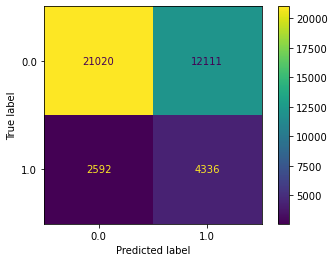

In [56]:
#predict using Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
notes = "No Outliers (NO), test on NO data, default parameters, robust scaled, upsamp"
modeling.run_test(X_train_robust_upsamp,X_test_robust,y_train_robust_upsamp,y_test, model, notes)

{'f1_score': 0.37110578568983227, 'recall_score': 0.625866050808314, 'precision_score': 0.2637469586374696, 'accuracy_score': 0.6331411168526424}


LogisticRegression()

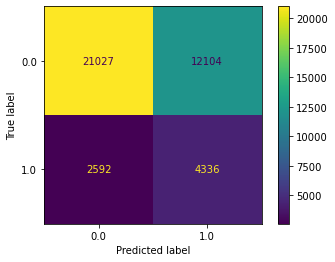

In [61]:
#predict using Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
notes = "No Outliers (NO), test on NO data, default parameters, stand scaled, upsamp"
modeling.run_test(X_train_stand_upsamp,X_test_stand,y_train_stand_upsamp,y_test, model, notes)

{'f1_score': 0.3716496387808319, 'recall_score': 0.6274538106235565, 'precision_score': 0.26401457637412695, 'accuracy_score': 0.6330662273147108}


LogisticRegression()

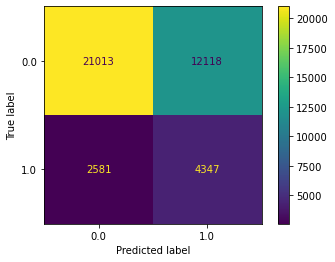

In [62]:
#predict using Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
notes = "No Outliers (NO), test on NO data, default parameters, robust scaled, dsamp"
modeling.run_test(X_train_robust_dsamp,X_test_robust,y_train_robust_dsamp,y_test, model, notes)

{'f1_score': 0.3714627682311704, 'recall_score': 0.6271651270207852, 'precision_score': 0.26387708004372645, 'accuracy_score': 0.6329414114181582}


LogisticRegression()

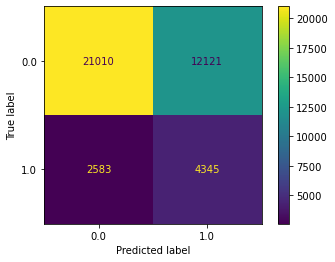

In [63]:
#predict using Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
notes = "No Outliers (NO), test on NO data, default parameters, stand scaled, dsamp"
modeling.run_test(X_train_stand_dsamp,X_test_stand,y_train_stand_dsamp,y_test, model, notes)

{'f1_score': 0.30866928291116663, 'recall_score': 0.31221131639722866, 'precision_score': 0.3052067165232115, 'accuracy_score': 0.7581317556604009}


GaussianNB()

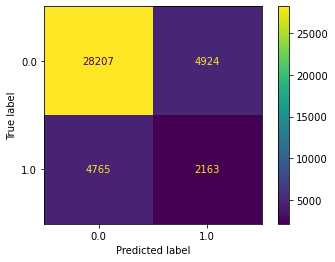

In [66]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
notes = "No Outliers (NO), test on NO data, default parameters, robust scaled, upsamp"
modeling.run_test(X_train_robust_upsamp,X_test_robust,y_train_robust_upsamp,y_test, model, notes)

{'f1_score': 0.30866928291116663, 'recall_score': 0.31221131639722866, 'precision_score': 0.3052067165232115, 'accuracy_score': 0.7581317556604009}


GaussianNB()

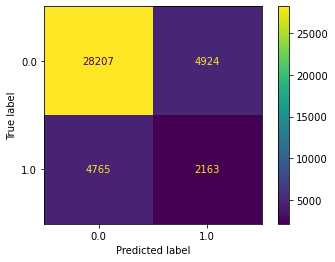

In [65]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
notes = "No Outliers (NO), test on NO data, default parameters, stand scaled, upsamp"
modeling.run_test(X_train_stand_upsamp,X_test_stand,y_train_stand_upsamp,y_test, model, notes)

{'f1_score': 0.28252788104089227, 'recall_score': 0.2632794457274827, 'precision_score': 0.3048128342245989, 'accuracy_score': 0.7687411068673706}


GaussianNB()

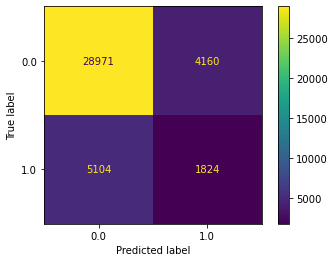

In [68]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
notes = "No Outliers (NO), test on NO data, default parameters, robust scaled, dsamp"
modeling.run_test(X_train_robust_dsamp,X_test_robust,y_train_robust_dsamp,y_test, model, notes)

{'f1_score': 0.28252788104089227, 'recall_score': 0.2632794457274827, 'precision_score': 0.3048128342245989, 'accuracy_score': 0.7687411068673706}


GaussianNB()

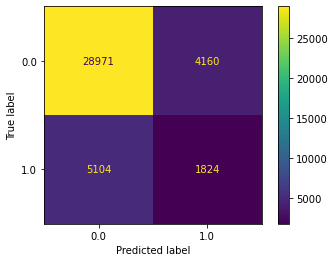

In [69]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
notes = "No Outliers (NO), test on NO data, default parameters, stand scaled, dsamp"
modeling.run_test(X_train_stand_dsamp,X_test_stand,y_train_stand_dsamp,y_test, model, notes)

{'f1_score': 0.28524590163934427, 'recall_score': 0.20092378752886836, 'precision_score': 0.4915254237288136, 'accuracy_score': 0.8258568611298335}


RandomForestClassifier(max_depth=100, random_state=0)

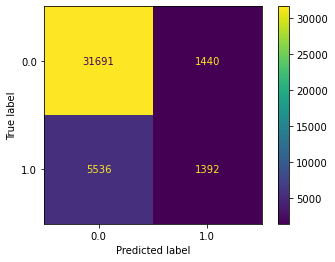

In [72]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=100, random_state=0)
notes = "NO, RFC, max_depth=100, robust, upsamp"
modeling.run_test(X_train_robust_upsamp,X_test_robust,y_train_robust_upsamp,y_test, model, notes)

{'f1_score': 0.2854802375588777, 'recall_score': 0.20121247113163973, 'precision_score': 0.49119097956307256, 'accuracy_score': 0.8258069347712125}


RandomForestClassifier(max_depth=100, random_state=0)

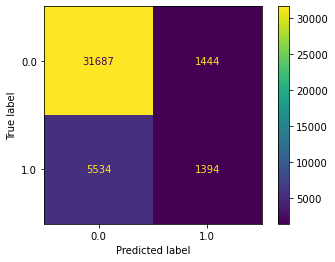

In [73]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=100, random_state=0)
notes = "NO, RFC, max_depth=100, stand, upsamp"
modeling.run_test(X_train_stand_upsamp,X_test_stand,y_train_stand_upsamp,y_test, model, notes)

{'f1_score': 0.40331855493613095, 'recall_score': 0.6631062355658198, 'precision_score': 0.28978742193906515, 'accuracy_score': 0.6606755036321426}


RandomForestClassifier(max_depth=100, random_state=0)

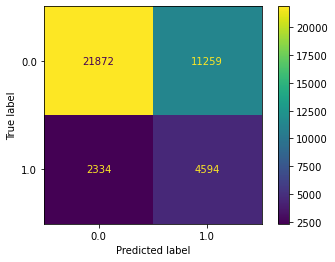

In [74]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=100, random_state=0)
notes = "NO, RFC, max_depth=100, robust, dsamp"
modeling.run_test(X_train_robust_dsamp,X_test_robust,y_train_robust_dsamp,y_test, model, notes)

{'f1_score': 0.40298507462686567, 'recall_score': 0.6625288683602771, 'precision_score': 0.289553368660106, 'accuracy_score': 0.660500761376969}


RandomForestClassifier(max_depth=100, random_state=0)

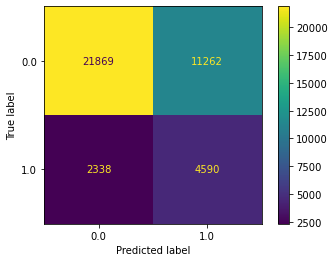

In [76]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=100, random_state=0)
notes = "NO, RFC, max_depth=100, stand , dsamp"
modeling.run_test(X_train_stand_dsamp,X_test_stand,y_train_stand_dsamp,y_test, model, notes)

{'f1_score': 0.3836873406966865, 'recall_score': 0.6518475750577367, 'precision_score': 0.27185167348904404, 'accuracy_score': 0.6378341945630196}


AdaBoostClassifier(n_estimators=100, random_state=0)

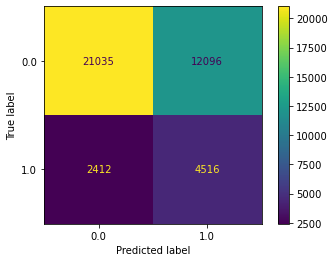

In [78]:
from sklearn.ensemble import AdaBoostClassifier
model =  AdaBoostClassifier(n_estimators=100, random_state=0)
notes = "NO, ada, max_depth=100, Robust , upsamp"
modeling.run_test(X_train_robust_upsamp,X_test_robust,y_train_robust_upsamp,y_test, model, notes)

{'f1_score': 0.3836873406966865, 'recall_score': 0.6518475750577367, 'precision_score': 0.27185167348904404, 'accuracy_score': 0.6378341945630196}


AdaBoostClassifier(n_estimators=100, random_state=0)

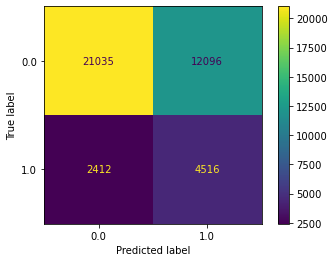

In [80]:
from sklearn.ensemble import AdaBoostClassifier
model =  AdaBoostClassifier(n_estimators=100, random_state=0)
notes = "NO, ada, n_estimators=100, stand , upsamp"
modeling.run_test(X_train_stand_upsamp,X_test_stand,y_train_stand_upsamp,y_test, model, notes)

{'f1_score': 0.38402588555858314, 'recall_score': 0.6509815242494227, 'precision_score': 0.2723429951690821, 'accuracy_score': 0.6388327217354403}


AdaBoostClassifier(n_estimators=100, random_state=0)

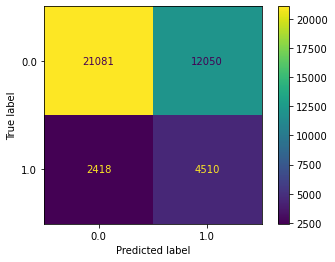

In [79]:
from sklearn.ensemble import AdaBoostClassifier
model =  AdaBoostClassifier(n_estimators=100, random_state=0)
notes = "NO, ada,n_estimators=100, Robust , dsamp"
modeling.run_test(X_train_robust_dsamp,X_test_robust,y_train_robust_dsamp,y_test, model, notes)

{'f1_score': 0.38402588555858314, 'recall_score': 0.6509815242494227, 'precision_score': 0.2723429951690821, 'accuracy_score': 0.6388327217354403}


AdaBoostClassifier(n_estimators=100, random_state=0)

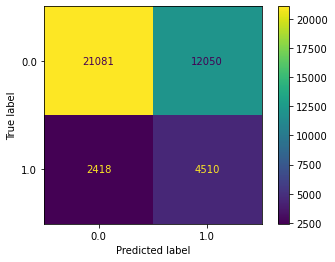

In [81]:
from sklearn.ensemble import AdaBoostClassifier
model =  AdaBoostClassifier(n_estimators=100, random_state=0)
notes = "NO, ada, n_estimators=100, stand , dsamp"
modeling.run_test(X_train_stand_dsamp,X_test_stand,y_train_stand_dsamp,y_test, model, notes)

# Evaluation Zone


In [55]:
#Evaluation Metrics for Logistic regression classifier Robust, note y_test is the original y-test, never modified.
print(f'accuracy is: {accuracy_score(y_test, y_pred)}')
print(f'f1_score is: {f1_score(y_test, y_pred)}')
print(f'The confusion matrix is: {pd.DataFrame(confusion_matrix(y_test, y_pred))}')
print(f'recall score is: {recall_score(y_test, y_pred)}')
print(f'precision score is: {precision_score(y_test,y_pred)}')

accuracy is: 0.6329663745974687
f1_score is: 0.37099465240641716
The confusion matrix is:        0      1
0  21020  12111
1   2592   4336
recall score is: 0.625866050808314
precision score is: 0.26363470541740136


In [119]:
modeling.get_records()

,model,notes,training_time,f1_score,recall_score,precision_score,accuracy_score
1.pickle,LogisticRegression,"No Outliers (NO), test on NO data, default par...",1.416287,0.370995,0.625866,0.263635,0.632966
2.pickle,LogisticRegression,"No Outliers (NO), test on NO data, default par...",0.679610,0.371106,0.625866,0.263747,0.633141
3.pickle,LogisticRegression,"No Outliers (NO), test on NO data, default par...",0.283257,0.371650,0.627454,0.264015,0.633066
4.pickle,LogisticRegression,"No Outliers (NO), test on NO data, default par...",0.140119,0.371463,0.627165,0.263877,0.632941
2.pickle,LogisticRegression,"No Outliers (NO), test on NO data, default par...",0.664604,0.371106,0.625866,0.263747,0.633141
3.pickle,LogisticRegression,"No Outliers (NO), test on NO data, default par...",0.277254,0.371650,0.627454,0.264015,0.633066
4.pickle,LogisticRegression,"No Outliers (NO), test on NO data, default par...",0.134112,0.371463,0.627165,0.263877,0.632941
5.pickle,GaussianNB,"No Outliers (NO), test on NO data, default par...",0.123112,0.308669,0.312211,0.305207,0.758132
6.pickle,GaussianNB,"No Outliers (NO), test on NO data, default par...",0.122101,0.308669,0.312211,0.305207,0.758132
7.pickle,GaussianNB,"No Outliers (NO), test on NO data, default par...",0.123112,0.308669,0.312211,0.305207,0.758132


Try RFE:

{'f1_score': 0.241171051284676, 'recall_score': 0.17003464203233257, 'precision_score': 0.41464273143259417, 'accuracy_score': 0.8149479517711375}


RFE(estimator=RandomForestClassifier(max_depth=100, n_estimators=300,
                                     random_state=0),
    n_features_to_select=20, step=2)

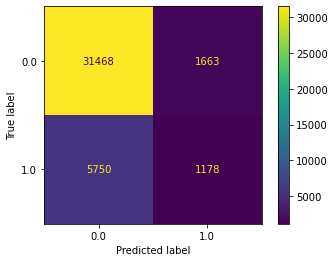

In [98]:
#Trying RFE To see if reduction of features help
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(n_estimators = 300, max_depth=100, random_state=0)
model = RFE(estimator, n_features_to_select=20, step=2)
notes = "NO, RFC with RFE, n_estimators, max_depth=100, 20 features, stand, upsamp"
modeling.run_test(X_train_stand_upsamp,X_test_stand,y_train_stand_upsamp,y_test, model, notes)

{'f1_score': 0.2907597535934292, 'recall_score': 0.20438799076212472, 'precision_score': 0.5035561877667141, 'accuracy_score': 0.8275543573229487}


RandomForestClassifier(max_depth=100, n_estimators=300, random_state=0)

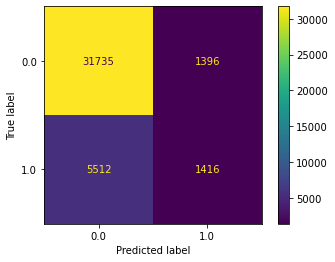

In [100]:
#Trying to using RFC, with a different parameter
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 300, max_depth=100, random_state=0)
notes = "NO, RFC, n_estimators= 300, max_depth=100, stand , upsamp"
modeling.run_test(X_train_stand_upsamp,X_test_stand,y_train_stand_upsamp,y_test, model, notes)

# Final Model tuning 
- Decided to use RandomForestClassifier - Best results relative to other models on baseline
- Decided to use Standardscalar - doesn't really make that big of a different if there are no outliers. 
- Downsampling gives me a higher recall -> more labeled as late, but are on time    

In [89]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = 50)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
              
print(random_grid)

{'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235, 267, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [104]:
# trying to use Randomizedsearch to optimize
RFC = RandomForestClassifier(random_state= 0)
random = RandomizedSearchCV(RFC, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#notes = 'Random_Grid search with RFC, '
#modeling.run_test(X_train_stand_dsamp,X_test_stand,y_train_stand_dsamp,y_test, random, notes)

In [106]:
#Trying with downsampled data
RFC_random = random.fit(X_train_stand_dsamp,y_train_stand_dsamp)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [120]:
#Trying with upsampled data - Didn't end up using this
RFC_random_up = random.fit(X_train_stand_upsamp,y_train_stand_upsamp)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [107]:
# best parameters for downsample
RFC_random.best_params_

{'n_estimators': 267,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 81,
 'bootstrap': False}

In [121]:
# best parameters for upsample
RFC_random_up.best_params_

{'n_estimators': 235,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 43,
 'bootstrap': False}

In [ ]:
# trying to use gridsearch to optimize Downsamples
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on RFC_random best parameters
param_grid = {
    'bootstrap': [False],
    'max_depth': [70, 75, 80, 85, 90],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [240, 250, 260, 270, 280]}
RFC = RandomForestClassifier(random_state= 0)
grid = GridSearchCV(RFC, param_grid, n_jobs = -1)
#notes = 'Random_Grid search with RFC, '
#modeling.run_test(X_train_stand_dsamp,X_test_stand,y_train_stand_dsamp,y_test, grid, notes)

In [124]:
# trying to use gridsearch to optimize upsamples
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on RFC_random best parameters
param_grid = {
    'bootstrap': [False],
    'max_depth': [40,41,42,43,44,45],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [220, 225, 230, 235, 240]}
RFC = RandomForestClassifier(random_state= 0)
grid2 = GridSearchCV(RFC, param_grid, n_jobs = -1)
#notes = 'Random_Grid search with RFC, '
#modeling.run_test(X_train_stand_dsamp,X_test_stand,y_train_stand_dsamp,y_test, grid, notes)

In [114]:
#Fitting the Random forest classifier with downsampled data for training metrics.
RFC_grid = grid.fit(X_train_stand_dsamp,y_train_stand_dsamp)

In [116]:
RFC_grid.best_params_

{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 280}

In [ ]:
RFC_grid_up = grid2.fit(X_train_stand_upsamp,y_train_stand_upsamp)

In [ ]:
RFC_grid_up.best_params

Running the best RFC model

{'f1_score': 0.4081186299811907, 'recall_score': 0.6733545034642032, 'precision_score': 0.29278855206175863, 'accuracy_score': 0.6622232207493947}


RandomForestClassifier(max_depth=70, min_samples_leaf=4, min_samples_split=4,
                       n_estimators=280, random_state=0)

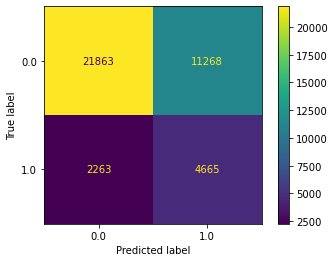

In [118]:
#Picked the best parameters from the RFC gridsearch, and used it to evaluate the training data. 
from sklearn.ensemble import RandomForestClassifier #Pickle27
model = RandomForestClassifier(n_estimators = 280, max_depth=70, max_features = 'auto', min_samples_leaf= 4, min_samples_split = 4, random_state=0)
notes = "NO, RFC after gridsearch, n_estimators = 280, max_depth=70, max_features = 'auto', min_samples_leaf= 4, min_samples_split = 4, stand, dsamp"
modeling.run_test(X_train_stand_dsamp,X_test_stand,y_train_stand_dsamp,y_test, model, notes)

# Pickling.

In [117]:
save_file = open('RFC_gridsearch.pickle', 'wb')
pickle.dump(RFC_grid,save_file)

In [2]:
save_file = open('../data/local/pickles/27.pickle', 'rb')
p = pickle.load(save_file)
save_file.close()
p

RandomForestClassifier(max_depth=70, min_samples_leaf=4, min_samples_split=4,
                       n_estimators=280, random_state=0)

# Getting Final predictions

In [5]:
#getting testing data for final prediction of data.
sys.path.append("..")  # <-  This should point to the root directory of the project relative to this file

from custom_scripts import database
from custom_scripts import preprocessing
from custom_scripts import preparation
from custom_scripts import modeling

test_flights_final = preprocessing.get_test_flights()